In [23]:
import uproot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

In [24]:
uproot.__version__

'5.0.9'

In [25]:
!ls ..

GNNKeras.ipynb                          MyxAODAnalysis_Data.outputs.root
LLP_for_Calo.ipynb                      MyxAODAnalysis_cluster.outputs.root
LLP_time-Copy1.ipynb                    Untitled.ipynb
LLP_time.ipynb                          ZacClub.ipynb
LLP_time_1.ipynb                        fixed_length.py
MLBasedCaloClustering                   karate.edgelist
ML_01.ipynb                             mlp-0000.params
ML_Cell_data                            mlp-symbol.json
ML_for_Calo.ipynb                       mxHybrid.ipynb
ML_for_Calo_students.ipynb              mxnet_exported_mlp.onnx
MyxAODAnalysis.outputs100LLPevnts.root  my_env
MyxAODAnalysis_100evnts.outputs.root    saved_model
MyxAODAnalysis_100evntsLLP.outputs.root trackML.ipynb


In [26]:
file = uproot.open("../MyxAODAnalysis_100evnts.outputs.root")

In [27]:
file.keys()

['analysis;1']

In [28]:
tree = file['analysis']

In [29]:
tree.keys() # no. of variables per event

['RunNumber',
 'EventNumber',
 'cell_eta',
 'cell_phi',
 'cell_x',
 'cell_y',
 'cell_z',
 'cell_subCalo',
 'cell_sampling',
 'cell_size',
 'cell_e',
 'cell_sigma',
 'cell_time',
 'cell_weight',
 'cell_truth',
 'cell_cluster_index',
 'cluster_to_cell_indices',
 'cluster_to_cell_weights',
 'cell_to_cluster_e',
 'cell_to_cluster_eta',
 'cell_to_cluster_phi',
 'cluster_eta',
 'cluster_phi',
 'cluster_e',
 'cellsNo_cluster',
 'clustersNo_event',
 'jet_energyWtdTimeAve']

In [30]:
branches = tree.arrays()

In [31]:
# this one just dealing with 1 event (e.g. 0th event)
cell_coordinate_x = branches['cell_x'][0]
cell_coordinate_y = branches['cell_y'][0]
cell_coordinate_z = branches['cell_z'][0]
cell_subCalo = branches['cell_subCalo'][0]
cell_sampling = branches['cell_sampling'][0]
cell_weight = branches['cell_weight'][0]
cell_truth = branches['cell_truth'][0]
cell_to_cluster_e = branches['cell_to_cluster_e'][0]
cell_sigma = branches['cell_sigma'][0]
cell_time = branches['cell_time'][0]
cellsNo_cluster = branches['cellsNo_cluster'][0]
clustersNo_event = branches['clustersNo_event'][0]
cell_cluster_index = branches['cell_cluster_index'][0]
cell_e = branches['cell_e'][0]

In [32]:
# convert them to numpy array otherwise they I believe behave like lists
cell_coordinate_x = np.array(cell_coordinate_x)
cell_coordinate_y = np.array(cell_coordinate_y)
cell_coordinate_z = np.array(cell_coordinate_z)
cell_subCalo = np.array(cell_subCalo)
cell_sampling = np.array(cell_sampling)
cell_weight = np.array(cell_weight)
cell_truth = np.array(cell_truth)
cell_to_cluster_e = np.array(cell_to_cluster_e)
cell_sigma = np.array(cell_sigma)
cell_time = np.array(cell_time)
cellsNo_cluster = np.array(cellsNo_cluster)
clustersNo_event = np.array(clustersNo_event)
cell_cluster_index = np.array(cell_cluster_index)
cell_e = np.array(cell_e)

In [33]:
branches['clustersNo_event'][0]

<Array [839] type='1 * int32'>

In [45]:
indices_tile = [i for i in range(len(cell_subCalo)) if cell_subCalo[i] == 3]

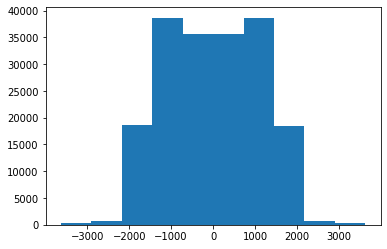

In [35]:
# cells contributing to a cluster
#LAREM = 0, LARHEC = 1, LARFCAL = 2, TILE = 3, LARMINIFCAL = 4, NSUBCALO = 5,
plt.hist(cell_coordinate_x)
plt.show()

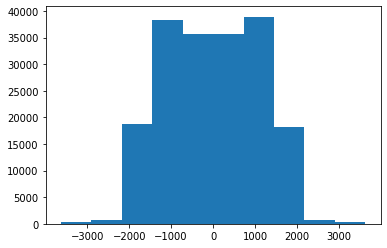

In [36]:
plt.hist(cell_coordinate_y)
plt.show()

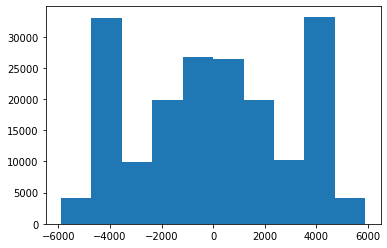

In [37]:
plt.hist(cell_coordinate_z)
plt.show()

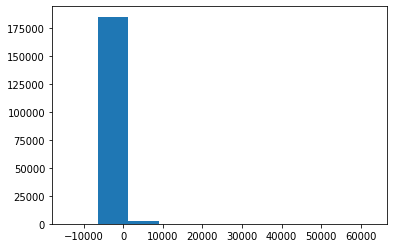

In [38]:
plt.hist(cell_e)
plt.show()

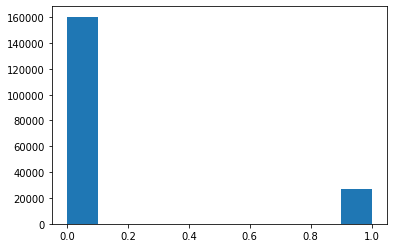

In [39]:
plt.hist(cell_truth)
plt.show()

In [48]:
cell_sigma_tile = cell_sigma[indices_tile]
cell_time_tile = cell_time[indices_tile]

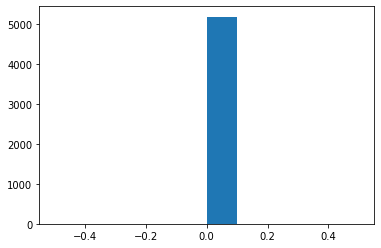

In [50]:
plt.hist(cell_time_tile)
plt.show()

0.0

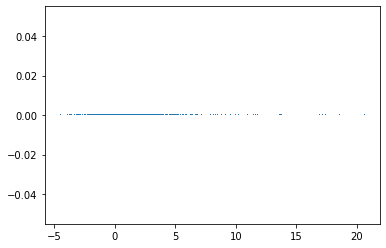

In [49]:
plt.plot(cell_sigma_tile, cell_time_tile, ',')
plt.show()

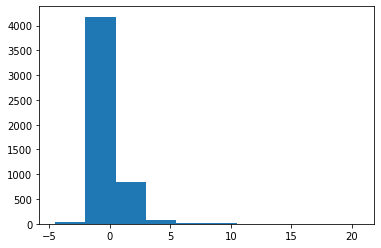

In [47]:
plt.hist(cell_sigma_tile)
plt.show()

In [19]:
indices_negE = [i for i in range(len(cell_e)) if cell_e[i] < 0]

In [20]:
cellTruthwithNegE = cell_truth[indices_negE]

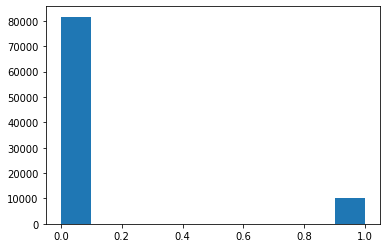

In [23]:
plt.hist(cellTruthwithNegE)
plt.show()

In [25]:
import pandas as pd

In [28]:
df = pd.DataFrame({"cell_coordinate_x":cell_coordinate_x,
                   "cell_coordinate_y":cell_coordinate_y,
                   "cell_coordinate_z":cell_coordinate_z,
                   "cell_truth":cell_truth,
                   "cell_weight":cell_weight,
                   "cell_noise":cell_sigma,
                   "cell_subCalo":cell_subCalo,
                   "cell_e":cell_e,
                  })

In [29]:
df.head()

,cell_coordinate_x,cell_coordinate_y,cell_coordinate_z,cell_truth,cell_weight,cell_noise,cell_subCalo,cell_e
0,616.838867,33.279976,-3970.418457,0,0.0,2000.014526,0,1153.415527
1,610.660461,93.484917,-3970.418457,0,0.0,2000.014282,0,-585.246765
2,598.610657,152.794373,-3970.418457,0,0.0,2000.014526,0,-2005.091553
3,580.805481,210.637146,-3970.418457,0,0.0,2000.014771,0,-29.105059
4,557.416626,266.456024,-3970.418457,0,0.0,2000.014526,0,-570.273132


In [79]:
arr = np.arange(187652)
np.random.shuffle(arr)

In [85]:
cell_coordinate_xrand = cell_coordinate_x[arr]
cell_coordinate_yrand = cell_coordinate_y[arr]
cell_coordinate_zrand = cell_coordinate_z[arr]
cell_truthrand = cell_truth[arr]
cell_noiserand = cell_sigma[arr]
cell_erand = cell_e[arr]

In [86]:
cell_coordinate_xrand.shape

(187652,)

In [87]:
cell_coordinate_xT = np.transpose(np.expand_dims(cell_coordinate_xrand , axis=0))
cell_coordinate_yT = np.transpose(np.expand_dims(cell_coordinate_yrand , axis=0))
cell_coordinate_zT = np.transpose(np.expand_dims(cell_coordinate_zrand , axis=0))
cell_truth_T = np.transpose(np.expand_dims(cell_truthrand , axis=0))
cell_noise_T = np.transpose(np.expand_dims(cell_noiserand , axis=0))
cell_e_T = np.transpose(np.expand_dims(cell_erand , axis=0))

In [88]:
cell_coordinate_xT.shape

(187652, 1)

In [89]:
features = np.concatenate((cell_coordinate_xT, cell_coordinate_yT, cell_coordinate_zT, cell_noise_T, cell_e_T),1)

In [90]:
features.shape

(187652, 5)

In [91]:
truth_label =  cell_truth_T

In [92]:
features_train, features_test, truth_label_train, truth_label_test = train_test_split(
    features, truth_label, train_size=0.70)

In [93]:
print("features: ",features_train.shape)
print("truth_label: ",truth_label_train.shape)

features:  (131356, 5)
truth_label:  (131356, 1)
